In [1]:
import numpy as np 
import pandas as pd

In [2]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import pandas_datareader as pdr

import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('yahoo_stock.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


In [8]:
df["Date"].min(), df["Date"].max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [9]:
df.set_index("Date",inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For all the columns')

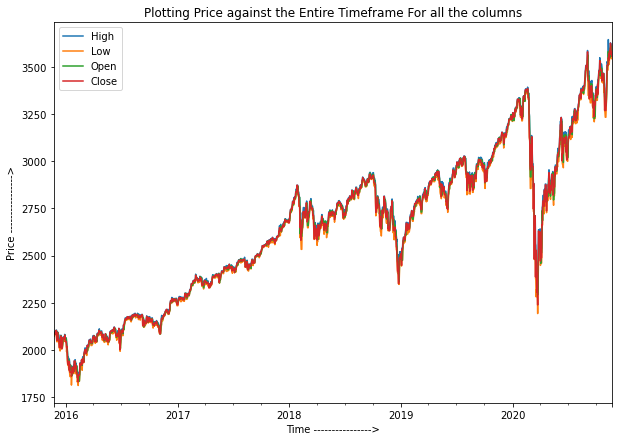

In [10]:
df[["High", "Low", "Open", "Close"]].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For all the columns")

Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For HIGH column')

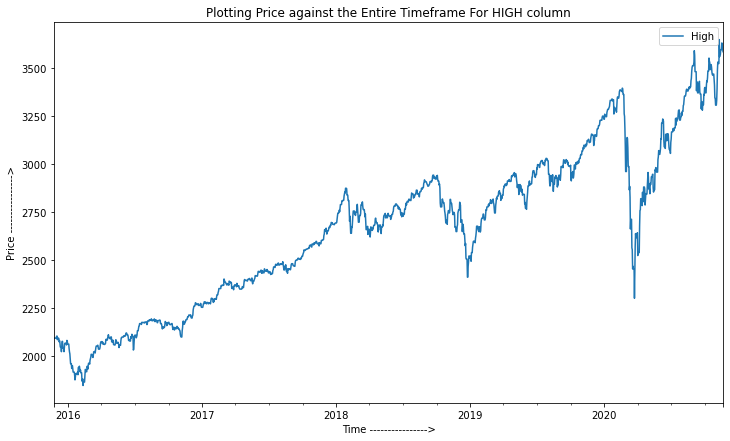

In [11]:
plt.figure(figsize=(12,7))
df["High"].plot()
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For HIGH column")

All 4 plots follow the same pattern, so we can choose any.

In [12]:
new_df = pd.DataFrame(df["High"].copy(), columns=["High"])
new_df.head()

,High
Date,
2015-11-23,2095.610107
2015-11-24,2094.120117
2015-11-25,2093.000000
2015-11-26,2093.000000
2015-11-27,2093.290039


In [13]:
train_size = int(len(new_df)*0.8)

train = new_df.iloc[0:train_size]
test = new_df.iloc[train_size:len(new_df)]

In [14]:
len(train), len(test)

(1460, 365)

In [15]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []
    
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

In [16]:
xtrain, ytrain = create_dataset(train, train["High"],10)
xtest, ytest = create_dataset(test, test["High"],10)

In [17]:
xtrain[0]

array([[2095.61010742],
       [2094.12011719],
       [2093.        ],
       [2093.        ],
       [2093.29003906],
       [2093.29003906],
       [2093.29003906],
       [2093.81005859],
       [2103.37011719],
       [2104.27001953]])

In [18]:
ytrain[0]

2085.0

In [19]:
xtrain.shape

(1450, 10, 1)

# LSTM Model

In [20]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

2023-01-07 22:38:53.998239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.fit(xtrain, ytrain,
         epochs=10,
         batch_size=10,
         verbose=1,
         shuffle=False
         )

Epoch 1/10
145/145 [==============================] - 2s 4ms/step - loss: 1059441.7500
Epoch 2/10
145/145 [==============================] - 1s 4ms/step - loss: 422.5907
Epoch 3/10
145/145 [==============================] - 1s 5ms/step - loss: 411.3903
Epoch 4/10
145/145 [==============================] - 1s 4ms/step - loss: 412.5698
Epoch 5/10
145/145 [==============================] - 1s 4ms/step - loss: 418.0900
Epoch 6/10
145/145 [==============================] - 1s 4ms/step - loss: 432.4976
Epoch 7/10
145/145 [==============================] - 1s 5ms/step - loss: 438.9678
Epoch 8/10
145/145 [==============================] - 1s 4ms/step - loss: 461.1429
Epoch 9/10
145/145 [==============================] - 1s 4ms/step - loss: 467.5881
Epoch 10/10
145/145 [==============================] - 1s 5ms/step - loss: 523.2260


In [22]:
ypred = model.predict(xtest)

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Entire Timeframe')

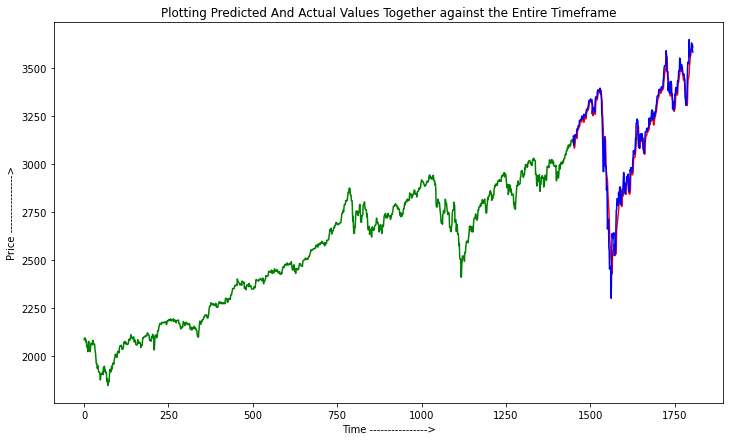

In [23]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Entire Timeframe")

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

58.59148512441027

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Testing Timeframe')

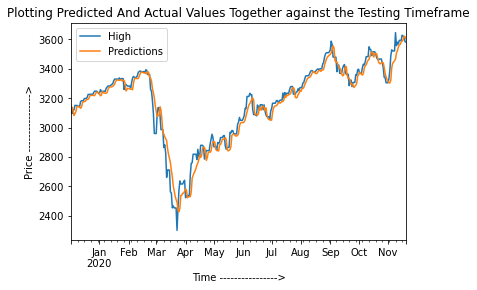

In [25]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

# LSTM Model with Two Layers

In [43]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu',
           input_shape=(10,1), 
           return_sequences=True))
model.add(Dropout(0.2))

# hidden layer 2
model.add(LSTM(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [44]:
#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=2,
#                                            verbose=0)]
model.fit(xtrain, ytrain, 
               epochs=20, batch_size=16,
               verbose=1
               #validation_split=0.05,
               )

Epoch 1/20
91/91 [==============================] - 3s 11ms/step - loss: 800396.5625
Epoch 2/20
91/91 [==============================] - 1s 10ms/step - loss: 345164.5625
Epoch 3/20
91/91 [==============================] - 1s 10ms/step - loss: 227171.8906
Epoch 4/20
91/91 [==============================] - 1s 10ms/step - loss: 194784.1250
Epoch 5/20
91/91 [==============================] - 1s 10ms/step - loss: 168304.9219
Epoch 6/20
91/91 [==============================] - 1s 10ms/step - loss: 152252.5938
Epoch 7/20
91/91 [==============================] - 1s 10ms/step - loss: 124363.7188
Epoch 8/20
91/91 [==============================] - 1s 11ms/step - loss: 122848.6641
Epoch 9/20
91/91 [==============================] - 1s 11ms/step - loss: 111147.0156
Epoch 10/20
91/91 [==============================] - 1s 11ms/step - loss: 126521.4922
Epoch 11/20
91/91 [==============================] - 1s 13ms/step - loss: 109751.5703
Epoch 12/20
91/91 [==============================] - 1s 9ms/ste

In [45]:
ypred = model.predict(xtest)

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together')

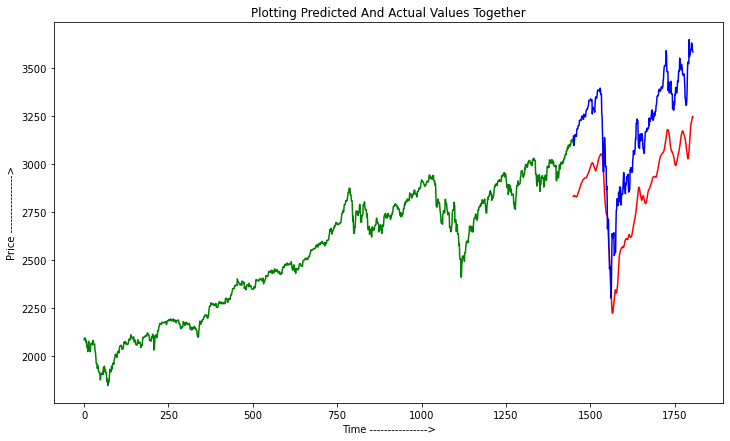

In [46]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together")

In [47]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

330.7699206870431

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Testing Timeframe')

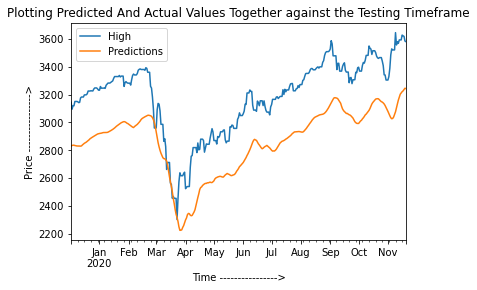

In [48]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

In [ ]:
Summarize the following code into a one-page business report:

import numpy as np 
import pandas as pd
import time
import pandas_datareader as pdr

import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv")
df.head()

df.info()

df["Date"] = pd.to_datetime(df["Date"])
df.info()

df["Date"].min(), df["Date"].max()

df.set_index("Date",inplace=True)
df.head()

df[["High", "Low", "Open", "Close"]].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For all the columns")

plt.figure(figsize=(12,7))
df["High"].plot()
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For HIGH column")

new_df = pd.DataFrame(df["High"].copy(), columns=["High"])
new_df.head()

train_size = int(len(new_df)*0.8)

train = new_df.iloc[0:train_size]
test = new_df.iloc[train_size:len(new_df)]

len(train), len(test)

def create_dataset(X, y, lag=1):
    xs,ys = [], []
    
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

xtrain, ytrain = create_dataset(train, train["High"],10)
xtest, ytest = create_dataset(test, test["High"],10)

xtrain[0]

ytrain[0]

xtrain.shape

model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(xtrain, ytrain,
         epochs=10,
         batch_size=10,
         verbose=1,
         shuffle=False
         )

ypred = model.predict(xtest)

plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Entire Timeframe")

from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

model = Sequential()
model.add(LSTM(100, activation='relu',
           input_shape=(10,1), 
           return_sequences=True))
model.add(Dropout(0.2))

# hidden layer 2
model.add(LSTM(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(xtrain, ytrain, 
               epochs=20, batch_size=16,
               verbose=1,
               #validation_split=0.05,
               )

ypred = model.predict(xtest)

plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together")

from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

